In [79]:
#import modules and renew token
from __future__ import print_function
import sys
import spotipy
import spotipy.util as util
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind
%matplotlib inline

username = "your user id"
client_id ="your client id" 
client_secret = "your client secret"
redirect_uri = 'http://localhost:7777/callback'

token = util.prompt_for_user_token(username=username, 
                                   scope=scope, 
                                   client_id=client_id,   
                                   client_secret=client_secret,     
                                   redirect_uri=redirect_uri)

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope, 
                                        client_id=client_id,   
                                        client_secret=client_secret,     
                                        redirect_uri=redirect_uri,
                                          show_dialog=True))

token
sp.me()

jehogan1223@gmail.com


{'display_name': 'Jack Hogan',
 'external_urls': {'spotify': 'https://open.spotify.com/user/jehogan1223'},
 'followers': {'href': None, 'total': 10},
 'href': 'https://api.spotify.com/v1/users/jehogan1223',
 'id': 'jehogan1223',
 'images': [],
 'type': 'user',
 'uri': 'spotify:user:jehogan1223'}

In [80]:
# username = 'jehogan1223'
# scope = 'user-library-read playlist-read-private'# playlist-read-private  playlist-modify-public'
# client_id ="8094db171b144addb652aa0cf2cc1e5a" 
# client_secret = "f5eb3081a4e642999f441cdecb344ecf"
# redirect_uri = 'http://localhost:7777/callback'
# print(username)
# token = 'none'

# sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope, 
#                                         client_id=client_id,   
#                                         client_secret=client_secret,     
#                                         redirect_uri=redirect_uri,
#                                           show_dialog=True))
# token
# #sp = spotipy.Spotify(auth=token)
# userId = sp.current_user()['id']
# userId
# sp.me()

In [81]:
#get 50 songs from user saved library
def get_songs(songoffset):
    tracknames = []
    ids = []
    dateadded = []

    if token:
        sp = spotipy.Spotify(auth=token)
        results = sp.current_user_saved_tracks(limit=50, offset = songoffset)
        playlists = sp.current_user_playlists(limit=50, offset=0)
        for item in results['items']:
            track = item['track']['name']
            trackid = item['track']['id']
            addedat = item['added_at']
            #print(trackid)
            #print(track['name'] + ' - ' + track['artists'][0]['name'])

            tracknames.append(track)
            #trackid = get_id(track['name'],token)
            ids.append(trackid)
            dateadded.append(addedat)
            #features = get_features(trackid, token)
            #trackfeatures.append(features)
    else:
        print("Can't get token for", username)
    features = sp.audio_features(ids) 
    df = pd.DataFrame(features)
    trackdesc = df.describe()
    mean = trackdesc.iloc[1]
    dfpca = df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
           'acousticness', 'instrumentalness', 'liveness', 'valence','tempo','duration_ms','time_signature']]
    
    tracknames = pd.DataFrame(tracknames,columns=['song_name'])
    dateadded = pd.DataFrame(dateadded,columns=['date_added'])
    df = pd.concat([df,tracknames,dateadded], axis = 1)
    
    return df

In [82]:
#get songs in multiples of 50, repeat for both users
#get songs in multiples of 50
start = 0
df = get_songs(start)
for i in range(start+1,start+9):
    offset = i*50
    dfcurrent = get_songs(offset)
    print(offset)
    df = pd.concat([df,dfcurrent])
    i += 1
df = df.reset_index(drop=True)
df['Label'] = 0
df0 = df

#get songs in multiples of 50
start = 70
df = get_songs(start)
for i in range(start+1,start+9):
    offset = i*50
    dfcurrent = get_songs(offset)
    print(offset)
    df = pd.concat([df,dfcurrent])
    i += 1
df = df.reset_index(drop=True)
df['Label'] = 1
df1 = df

50
100
150
200
250
300
350
400
3550
3600
3650
3700
3750
3800
3850
3900


              precision    recall  f1-score   support

           0       0.68      0.72      0.70       450
           1       0.70      0.66      0.68       450

    accuracy                           0.69       900
   macro avg       0.69      0.69      0.69       900
weighted avg       0.69      0.69      0.69       900

energy              0.509354
loudness            0.489995
acousticness        0.430083
valence             0.355168
danceability        0.242989
instrumentalness    0.231393
speechiness         0.221717
liveness            0.156491
tempo               0.039285
mode                0.037196
key                 0.013637
Name: 0, dtype: float64
speechiness         0.511735
danceability        0.367394
valence             0.367299
instrumentalness    0.326647
acousticness        0.324675
loudness            0.318636
energy              0.277631
liveness            0.214201
tempo               0.165128
mode                0.051987
key                 0.040838
Name: 1, dt

,pca0,pca1,Label,index
0,1.554937,-0.412486,0,0
1,-0.695486,-0.285565,0,1
2,-0.542037,0.176490,2,2
3,0.937323,0.501390,0,3
4,0.448001,-2.209517,0,4
...,...,...,...,...
895,1.963517,-1.020290,1,895
896,-2.691451,1.149381,1,896
897,-2.758875,0.022691,1,897
898,-2.099934,-0.264817,1,898


<Figure size 576x576 with 0 Axes>

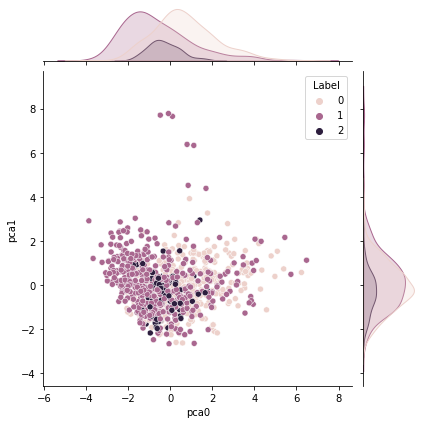

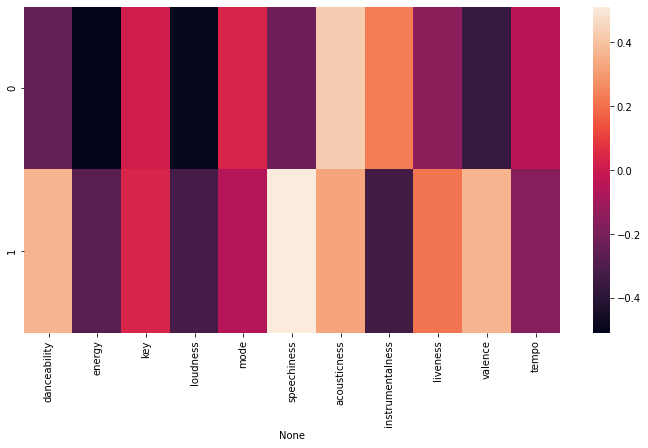

In [83]:
#create model for classifying songs for each user
#create list of songs which model has lowest confidence in classifying, represents the songs users tastes have in common

dfall = pd.concat([df0, df1]).reset_index(drop=True)
numsongs = len(dfall)

dfall = dfall.reset_index(drop=True)

X = dfall[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence','tempo']]

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

from sklearn.model_selection import train_test_split

y = dfall['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#fit on everything
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X,y)

predictions = logmodel.predict(X)
predictionsproba = logmodel.predict_proba(X)
from sklearn.metrics import classification_report
print(classification_report(y,predictions))

plusminus = 0
playlistlength = 90 #not over 95
sharedliked = []
while len(sharedliked) < playlistlength:
    sharedliked = []
    plusminus += .0001
    for predict in enumerate(predictionsproba):
        if .50-plusminus < predict[1][0] < .50+plusminus:
            sharedliked.append(predict[0])
    #print(len(sharedliked))
sharedliked
sharedlikedsongs = dfall.iloc[sharedliked]

from sklearn.utils import shuffle
sharedlikedsongsshuffled = shuffle(sharedlikedsongs).reset_index(drop=True)

len(sharedliked)

dfallmod = dfall
dfallmod.loc[sharedliked,'Label'] = 2

#dfboth = pd.concat([dfJack,dfAmy]).reset_index(drop=True)

dfallfeatures = dfall[['danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo']]

scaler = StandardScaler()
scaler.fit(dfallfeatures)
dfscaled = scaler.transform(dfallfeatures)
dfscaled = pd.DataFrame(dfscaled,columns=dfallfeatures.columns)

pca = PCA(n_components=2)
pca.fit(dfscaled)
x_pca = pca.transform(dfscaled)
dfx_pca = pd.DataFrame(x_pca,columns=['pca0','pca1'])
dfx_pca['Label'] = dfall['Label']
dfx_pca['index'] = dfall.index

# fig = plt.figure()
# plt.fig(figsize=(15,15))
# ax1 = fig.add_subplot(111)
plt.figure(figsize=(8, 8))
#sns.scatterplot(data=dfx_pca, x='pca0', y="pca1",hue='Label',size="index")
sns.jointplot(data=dfx_pca, x='pca0', y="pca1",hue='Label',cmap='plasma')

pca.components_
df_comp = pd.DataFrame(pca.components_,columns=[dfscaled.columns])
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,)
print(df_comp.iloc[0].abs().sort_values(ascending=False))
print(df_comp.iloc[1].abs().sort_values(ascending=False))
dfx_pca

In [84]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
normalizer = preprocessing.Normalization()
from sklearn.model_selection import train_test_split

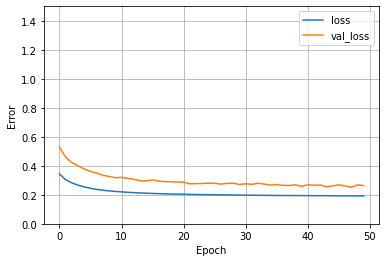

In [85]:
dfall = pd.concat([df0, df1]).reset_index(drop=True)
numsongs = len(dfall)

X = dfall[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence','tempo']]

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

from sklearn.model_selection import train_test_split

y = dfall['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = keras.Sequential()

model.add(Dense(8, activation='relu'))
#model.add(Dense(64, activation='relu'))
model.add(Dense(units=1))

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss='mean_squared_error')
#history = model.fit(X_train,y_train,validation_split=0.2,verbose=0,epochs=50,batch_size = 100)
#%%time

history = model.fit(
    X, y,
    validation_split=0.1,
    verbose=0, epochs=50)

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1.5])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

              precision    recall  f1-score   support

           0       0.66      0.84      0.74       450
           1       0.78      0.56      0.65       450

    accuracy                           0.70       900
   macro avg       0.72      0.70      0.69       900
weighted avg       0.72      0.70      0.69       900

90
energy              0.509354
loudness            0.489995
acousticness        0.430083
valence             0.355168
danceability        0.242989
instrumentalness    0.231393
speechiness         0.221717
liveness            0.156491
tempo               0.039285
mode                0.037196
key                 0.013637
Name: 0, dtype: float64
speechiness         0.511735
danceability        0.367394
valence             0.367299
instrumentalness    0.326647
acousticness        0.324675
loudness            0.318636
energy              0.277631
liveness            0.214201
tempo               0.165128
mode                0.051987
key                 0.040838
Name: 1,

,pca0,pca1,Label,index
0,1.554937,-0.412486,0,0
1,-0.695486,-0.285565,0,1
2,-0.542037,0.176490,0,2
3,0.937323,0.501390,0,3
4,0.448001,-2.209517,0,4
...,...,...,...,...
895,1.963517,-1.020290,2,895
896,-2.691451,1.149381,1,896
897,-2.758875,0.022691,1,897
898,-2.099934,-0.264817,1,898


<Figure size 576x576 with 0 Axes>

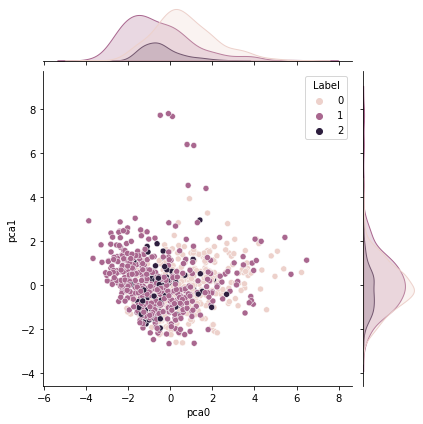

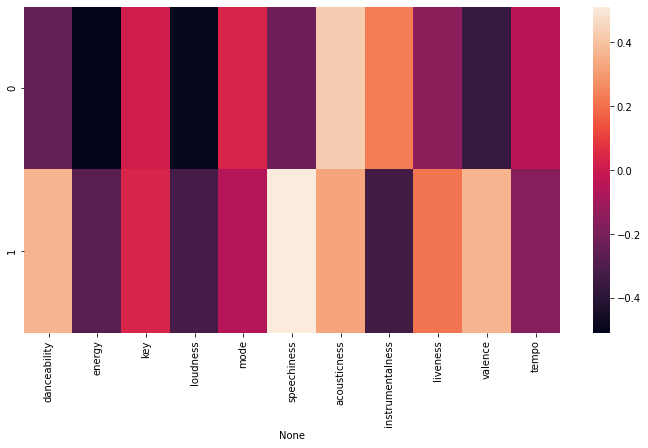

In [86]:
predictions = model.predict(X)
# predictionsproba = model.predict_proba(X)
# predictionsproba
from sklearn.metrics import classification_report
print(classification_report(y,np.round(predictions)))
plusminus = 0
playlistlength = 90 #not over 95
sharedliked = []
while len(sharedliked) < playlistlength:
    sharedliked = []
    plusminus += .0001
    for predict in enumerate(predictions):
        if .50-plusminus < predict[1][0] < .50+plusminus:
            sharedliked.append(predict[0])
    #print(len(sharedliked))
sharedliked
sharedlikedsongs = dfall.iloc[sharedliked]

from sklearn.utils import shuffle
sharedlikedsongsshuffled = shuffle(sharedlikedsongs).reset_index(drop=True)

print(len(sharedliked))

dfallmod = dfall
dfallmod.loc[sharedliked,'Label'] = 2

#dfboth = pd.concat([dfJack,dfAmy]).reset_index(drop=True)

dfallfeatures = dfall[['danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo']]

scaler = StandardScaler()
scaler.fit(dfallfeatures)
dfscaled = scaler.transform(dfallfeatures)
dfscaled = pd.DataFrame(dfscaled,columns=dfallfeatures.columns)

pca = PCA(n_components=2)
pca.fit(dfscaled)
x_pca = pca.transform(dfscaled)
dfx_pca = pd.DataFrame(x_pca,columns=['pca0','pca1'])
dfx_pca['Label'] = dfall['Label']
dfx_pca['index'] = dfall.index

# fig = plt.figure()
# plt.fig(figsize=(15,15))
# ax1 = fig.add_subplot(111)
plt.figure(figsize=(8, 8))
#sns.scatterplot(data=dfx_pca, x='pca0', y="pca1",hue='Label',size="index")
sns.jointplot(data=dfx_pca, x='pca0', y="pca1",hue='Label',cmap='plasma')

pca.components_
df_comp = pd.DataFrame(pca.components_,columns=[dfscaled.columns])
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,)
print(df_comp.iloc[0].abs().sort_values(ascending=False))
print(df_comp.iloc[1].abs().sort_values(ascending=False))
dfx_pca

91
energy              0.509354
loudness            0.489995
acousticness        0.430083
valence             0.355168
danceability        0.242989
instrumentalness    0.231393
speechiness         0.221717
liveness            0.156491
tempo               0.039285
mode                0.037196
key                 0.013637
Name: 0, dtype: float64
speechiness         0.511735
danceability        0.367394
valence             0.367299
instrumentalness    0.326647
acousticness        0.324675
loudness            0.318636
energy              0.277631
liveness            0.214201
tempo               0.165128
mode                0.051987
key                 0.040838
Name: 1, dtype: float64


,pca0,pca1,Label,index
0,1.554937,-0.412486,0,0
1,-0.695486,-0.285565,0,1
2,-0.542037,0.176490,2,2
3,0.937323,0.501390,0,3
4,0.448001,-2.209517,0,4
...,...,...,...,...
895,1.963517,-1.020290,1,895
896,-2.691451,1.149381,1,896
897,-2.758875,0.022691,1,897
898,-2.099934,-0.264817,1,898


<Figure size 576x576 with 0 Axes>

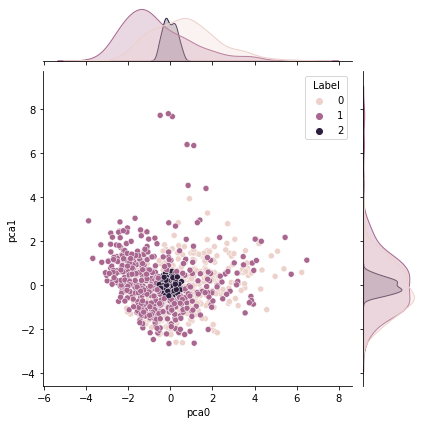

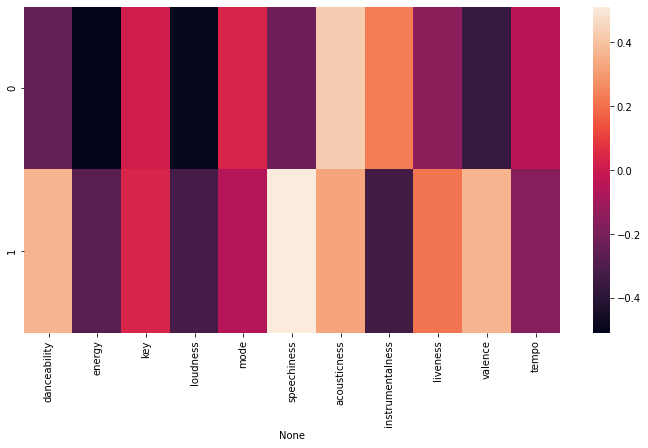

In [87]:
dfall = pd.concat([df0, df1]).reset_index(drop=True)

dfallfeatures = dfall[['danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo']]

scaler = StandardScaler()
scaler.fit(dfallfeatures)
dfscaled = scaler.transform(dfallfeatures)
dfscaled = pd.DataFrame(dfscaled,columns=dfallfeatures.columns)

pca = PCA(n_components=2)
pca.fit(dfscaled)
x_pca = pca.transform(dfscaled)
dfx_pca = pd.DataFrame(x_pca,columns=['pca0','pca1'])
dfx_pca['Label'] = dfall['Label']
dfx_pca['index'] = dfall.index
dfx_pca

radius = 0
playlistlength = 90 #not over 95
sharedliked = []
while len(sharedliked) < playlistlength:
    sharedliked = []
    radius += .01
    for index, row in dfx_pca.iterrows():
        if (row['pca0']**2 + row['pca1']**2) < radius:
            sharedliked.append(index)

#         if .50-plusminus < predict[1][0] < .50+plusminus:
#             sharedliked.append(predict[0])
    #print(len(sharedliked))
sharedliked
sharedlikedsongs = dfall.iloc[sharedliked]

from sklearn.utils import shuffle
sharedlikedsongsshuffled = shuffle(sharedlikedsongs).reset_index(drop=True)

print(len(sharedliked))

dfallmod = dfall
dfallmod.loc[sharedliked,'Label'] = 2

#dfboth = pd.concat([dfJack,dfAmy]).reset_index(drop=True)

dfallfeatures = dfall[['danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo']]

scaler = StandardScaler()
scaler.fit(dfallfeatures)
dfscaled = scaler.transform(dfallfeatures)
dfscaled = pd.DataFrame(dfscaled,columns=dfallfeatures.columns)

pca = PCA(n_components=2)
pca.fit(dfscaled)
x_pca = pca.transform(dfscaled)
dfx_pca = pd.DataFrame(x_pca,columns=['pca0','pca1'])
dfx_pca['Label'] = dfall['Label']
dfx_pca['index'] = dfall.index

# fig = plt.figure()
# plt.fig(figsize=(15,15))
# ax1 = fig.add_subplot(111)
plt.figure(figsize=(8, 8))
#sns.scatterplot(data=dfx_pca, x='pca0', y="pca1",hue='Label',size="index")
sns.jointplot(data=dfx_pca, x='pca0', y="pca1",hue='Label',cmap='plasma')

pca.components_
df_comp = pd.DataFrame(pca.components_,columns=[dfscaled.columns])
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,)
print(df_comp.iloc[0].abs().sort_values(ascending=False))
print(df_comp.iloc[1].abs().sort_values(ascending=False))
dfx_pca

In [88]:
## Create playlist in Spotify ##
#playlist will be create using the shared songs generated by either logistic regression, neural network, or PCA analysis, 
#whichever has been run most recently

In [89]:
#create playlist
#add songs to playlist
playlistname = 'Common Sound'

#get playlist names
playlists = sp.current_user_playlists(limit=50, offset=0)
playlistnames = []
playlistids = []
playlistdict = {}
while playlists:
    for i, playlist in enumerate(playlists['items']):
        #print("%4d %s %s" % (i + 1 + playlists['offset'], playlist['uri'],  playlist['name']))
        playlistnames.append(playlist['name'])
        playlistids.append(playlist['uri'])
        playlistdict[playlist['name']]=playlist['uri']
    if playlists['next']:
        playlists = sp.next(playlists)
    else:
        playlists = None
testusername = sp.current_user()['id']
print(testusername)
if playlistname not in playlistnames:
    if token:
        sp = spotipy.Spotify(auth=token)
        sp.user_playlist_create(sp.current_user()['id'], name=playlistname)
#need to get playlist names again if a new playlist was created
    playlists = sp.current_user_playlists(limit=50, offset=0)
    playlistnames = []
    playlistids = []
    playlistdict = {}
    while playlists:
        for i, playlist in enumerate(playlists['items']):
            #print("%4d %s %s" % (i + 1 + playlists['offset'], playlist['uri'],  playlist['name']))
            playlistnames.append(playlist['name'])
            playlistids.append(playlist['uri'])
            playlistdict[playlist['name']]=playlist['uri']
        if playlists['next']:
            playlists = sp.next(playlists)
        else:
            playlists = None

playlistid = playlistdict[playlistname]

if token:
    sp = spotipy.Spotify(auth=token)
   # sp.user_playlist_create(sp.current_user()['id'], name=playlistname)
    sp.playlist_replace_items(playlistid, sharedlikedsongsshuffled['id'])

jehogan1223


In [ ]:
# define functions for pulling song features from public playlists and saved music

def get_playlist_features(playlist_id):
    import pandas as pd 
    import spotipy 
    sp = spotipy.Spotify() 
    from spotipy.oauth2 import SpotifyClientCredentials
    cid ="8094db171b144addb652aa0cf2cc1e5a" 
    secret = "f5eb3081a4e642999f441cdecb344ecf" 
    client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) 
    sp.trace=False
    #results = sp.current_user_saved_tracks()
    playlist = sp.user_playlist("jehogan1223",playlist_id)
    #playlist = sp.user_playlist("jehogan1223",'spotify:playlist:37i9dQZF1ELYkGpoXXHefk')
    songs = playlist["tracks"]["items"] 
    tracknames = []
    ids = []
    dateadded = []
    for i in range(len(songs)-10): 
        ids.append(songs[i]["track"]["id"])
        tracknames.append(songs[i]["track"]["name"])
        dateadded.append(songs[i]['added_at'])

    features = sp.audio_features(ids) 
    dfplaylist = pd.DataFrame(features)

    tracknames = pd.DataFrame(tracknames,columns=['song_name'])
    dateadded = pd.DataFrame(dateadded,columns=['date_added'])

    dfplaylist = pd.concat([tracknames,dateadded,dfplaylist], axis = 1)
    #dfplaylist['Label'] = 'Jack'

    dfplaylistfeatures = dfplaylist[['danceability', 'energy', 'key', 'loudness',
           'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
           'valence', 'tempo']]
    return dfplaylist

#get 50 songs from user saved library
def get_songs(songoffset):
    tracknames = []
    ids = []
    dateadded = []

    if token:
        sp = spotipy.Spotify(auth=token)
        results = sp.current_user_saved_tracks(limit=50, offset = songoffset)
        playlists = sp.current_user_playlists(limit=50, offset=0)
        for item in results['items']:
            track = item['track']['name']
            trackid = item['track']['id']
            addedat = item['added_at']
            #print(trackid)
            #print(track['name'] + ' - ' + track['artists'][0]['name'])

            tracknames.append(track)
            #trackid = get_id(track['name'],token)
            ids.append(trackid)
            dateadded.append(addedat)
            #features = get_features(trackid, token)
            #trackfeatures.append(features)
    else:
        print("Can't get token for", username)
    features = sp.audio_features(ids) 
    df = pd.DataFrame(features)
    trackdesc = df.describe()
    mean = trackdesc.iloc[1]
    dfpca = df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
           'acousticness', 'instrumentalness', 'liveness', 'valence','tempo','duration_ms','time_signature']]
    
    tracknames = pd.DataFrame(tracknames,columns=['song_name'])
    dateadded = pd.DataFrame(dateadded,columns=['date_added'])
    df = pd.concat([df,tracknames,dateadded], axis = 1)
    
    return df

In [7]:
## enter playlist ids in playlist list (need at least 2)
#persons names in names list, for labeling only
playlists = []
names = []

playlists = ['spotify:playlist:37i9dQZF1EM2cBiYfyvZdu','37i9dQZF1ELVFJQgDR4rUs']
names = ['Jack','Wyatt']

dfall = get_playlist_features(playlists[0])
dfall['Label'] = names[0]
count = 1
for i in range(1,len(names)):
    dffeatures = get_playlist_features(playlists[i])
    dffeatures['Label'] = names[i]
    dfall = pd.concat([dfall,dffeatures])
    count += 1
dfall = dfall.reset_index()#(drop=True)
dfall['index'] = 10/(dfall['index']+1)
dfall

,index,song_name,date_added,danceability,energy,key,loudness,mode,speechiness,acousticness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,Label
0,10.000000,Outside,2020-11-27T12:32:23Z,0.637,0.613,1,-7.432,1,0.0272,0.0925,...,0.598,127.006,audio_features,7Cx3kiPstZOSKAqTe3LtEi,spotify:track:7Cx3kiPstZOSKAqTe3LtEi,https://api.spotify.com/v1/tracks/7Cx3kiPstZOS...,https://api.spotify.com/v1/audio-analysis/7Cx3...,238020,4,Jack
1,5.000000,Hahaha Pt. 2,2020-11-27T12:32:23Z,0.353,0.767,4,-6.491,0,0.0370,0.1490,...,0.495,108.025,audio_features,534O211S3LSiQsL5fE6EIv,spotify:track:534O211S3LSiQsL5fE6EIv,https://api.spotify.com/v1/tracks/534O211S3LSi...,https://api.spotify.com/v1/audio-analysis/534O...,241360,3,Jack
2,3.333333,Milk & Honey,2020-11-27T12:32:23Z,0.291,0.563,11,-9.120,0,0.0455,0.6780,...,0.457,81.467,audio_features,1GNBUGLY90p5vP6z1eEA7k,spotify:track:1GNBUGLY90p5vP6z1eEA7k,https://api.spotify.com/v1/tracks/1GNBUGLY90p5...,https://api.spotify.com/v1/audio-analysis/1GNB...,238653,4,Jack
3,2.500000,Realla,2020-11-27T12:32:23Z,0.628,0.601,5,-8.452,1,0.0505,0.4510,...,0.235,129.980,audio_features,1HL90u8MrrXtqNonXYN5of,spotify:track:1HL90u8MrrXtqNonXYN5of,https://api.spotify.com/v1/tracks/1HL90u8MrrXt...,https://api.spotify.com/v1/audio-analysis/1HL9...,210449,4,Jack
4,2.000000,Swim High,2020-11-27T12:32:23Z,0.444,0.615,1,-7.408,0,0.0770,0.3620,...,0.151,119.824,audio_features,4xKaAIRMff688GtmmDrvhh,spotify:track:4xKaAIRMff688GtmmDrvhh,https://api.spotify.com/v1/tracks/4xKaAIRMff68...,https://api.spotify.com/v1/audio-analysis/4xKa...,348000,4,Jack
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.116279,Roll The Bones - Audiotree Live Version,2020-11-27T11:12:48Z,0.597,0.549,1,-10.253,1,0.0586,0.6510,...,0.204,122.801,audio_features,1Yxbxg5R6dQcYmOdjvlXP0,spotify:track:1Yxbxg5R6dQcYmOdjvlXP0,https://api.spotify.com/v1/tracks/1Yxbxg5R6dQc...,https://api.spotify.com/v1/audio-analysis/1Yxb...,291596,4,Wyatt
176,0.114943,Bass Chalice,2020-11-27T11:12:48Z,0.785,0.652,0,-5.808,1,0.0745,0.0228,...,0.866,82.069,audio_features,3BJM8aHfLmZSkglGm9MAcR,spotify:track:3BJM8aHfLmZSkglGm9MAcR,https://api.spotify.com/v1/tracks/3BJM8aHfLmZS...,https://api.spotify.com/v1/audio-analysis/3BJM...,272093,4,Wyatt
177,0.113636,El Cuarto de Tula,2020-11-27T11:12:48Z,0.552,0.664,9,-13.167,1,0.0454,0.5950,...,0.858,104.776,audio_features,7dRfobhDNnsEgB2ZArxA1f,spotify:track:7dRfobhDNnsEgB2ZArxA1f,https://api.spotify.com/v1/tracks/7dRfobhDNnsE...,https://api.spotify.com/v1/audio-analysis/7dRf...,444533,4,Wyatt
178,0.112360,Chala Vahi Des,2020-11-27T11:12:48Z,0.603,0.550,9,-7.292,1,0.0480,0.5090,...,0.246,92.036,audio_features,6w7vPU1ciri3iiDBVkWJwa,spotify:track:6w7vPU1ciri3iiDBVkWJwa,https://api.spotify.com/v1/tracks/6w7vPU1ciri3...,https://api.spotify.com/v1/audio-analysis/6w7v...,256293,4,Wyatt


In [4]:
X = dfall[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence','tempo']]
y = dfall['Label']

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

from sklearn.model_selection import train_test_split

#y = allsongfeatures['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#fit on everything
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X,y)

predictions = logmodel.predict(X)
predictionsproba = logmodel.predict_proba(X)
from sklearn.metrics import classification_report
print(classification_report(y,predictions))


plusminus = 0
sharedliked = []
while len(sharedliked) < 19:
    sharedliked = []
    plusminus += .001
    for predict in enumerate(predictionsproba):
        if .50-plusminus < predict[1][0] < .50+plusminus:
            sharedliked.append(predict[0])
print(len(sharedliked))
sharedliked
sharedlikedsongs = dfall.iloc[sharedliked]

from sklearn.utils import shuffle
sharedlikedsongsshuffled = shuffle(sharedlikedsongs).reset_index(drop=True)
sharedlikedsongs

              precision    recall  f1-score   support

        Jack       0.83      0.79      0.81        90
       Wyatt       0.80      0.83      0.82        90

    accuracy                           0.81       180
   macro avg       0.81      0.81      0.81       180
weighted avg       0.81      0.81      0.81       180

19


,index,song_name,date_added,danceability,energy,key,loudness,mode,speechiness,acousticness,...,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,Label
0,10.000000,Outside,2020-11-27T12:32:23Z,0.637,0.613,1,-7.432,1,0.0272,0.09250,...,0.598,127.006,audio_features,7Cx3kiPstZOSKAqTe3LtEi,spotify:track:7Cx3kiPstZOSKAqTe3LtEi,https://api.spotify.com/v1/tracks/7Cx3kiPstZOS...,https://api.spotify.com/v1/audio-analysis/7Cx3...,238020,4,Jack
1,5.000000,Hahaha Pt. 2,2020-11-27T12:32:23Z,0.353,0.767,4,-6.491,0,0.0370,0.14900,...,0.495,108.025,audio_features,534O211S3LSiQsL5fE6EIv,spotify:track:534O211S3LSiQsL5fE6EIv,https://api.spotify.com/v1/tracks/534O211S3LSi...,https://api.spotify.com/v1/audio-analysis/534O...,241360,3,Jack
2,3.333333,Milk & Honey,2020-11-27T12:32:23Z,0.291,0.563,11,-9.120,0,0.0455,0.67800,...,0.457,81.467,audio_features,1GNBUGLY90p5vP6z1eEA7k,spotify:track:1GNBUGLY90p5vP6z1eEA7k,https://api.spotify.com/v1/tracks/1GNBUGLY90p5...,https://api.spotify.com/v1/audio-analysis/1GNB...,238653,4,Jack
3,2.500000,Realla,2020-11-27T12:32:23Z,0.628,0.601,5,-8.452,1,0.0505,0.45100,...,0.235,129.980,audio_features,1HL90u8MrrXtqNonXYN5of,spotify:track:1HL90u8MrrXtqNonXYN5of,https://api.spotify.com/v1/tracks/1HL90u8MrrXt...,https://api.spotify.com/v1/audio-analysis/1HL9...,210449,4,Jack
21,0.454545,Whiplash (feat. Tame Impala),2020-11-27T12:32:23Z,0.718,0.850,9,-5.586,1,0.1120,0.01850,...,0.375,102.896,audio_features,5iy3a8zOSVWrN8WyB0Zcqn,spotify:track:5iy3a8zOSVWrN8WyB0Zcqn,https://api.spotify.com/v1/tracks/5iy3a8zOSVWr...,https://api.spotify.com/v1/audio-analysis/5iy3...,170965,4,Jack
23,0.416667,Whatever Comes to Mind,2020-11-27T12:32:23Z,0.542,0.468,10,-7.796,1,0.0265,0.57900,...,0.252,130.829,audio_features,0ntyYV99MFp7f7MGZlwYj4,spotify:track:0ntyYV99MFp7f7MGZlwYj4,https://api.spotify.com/v1/tracks/0ntyYV99MFp7...,https://api.spotify.com/v1/audio-analysis/0nty...,249305,4,Jack
41,0.238095,Hunnybee,2020-11-27T12:32:23Z,0.956,0.373,6,-7.963,1,0.0773,0.56900,...,0.568,119.994,audio_features,3DPFmwFtV5ElQaTniLOdgk,spotify:track:3DPFmwFtV5ElQaTniLOdgk,https://api.spotify.com/v1/tracks/3DPFmwFtV5El...,https://api.spotify.com/v1/audio-analysis/3DPF...,268333,4,Jack
44,0.222222,Hallucinogenics,2020-11-27T12:32:23Z,0.549,0.653,0,-7.470,1,0.0503,0.45700,...,0.287,121.348,audio_features,6bLU8e0LGyztE9iD5DWBQ1,spotify:track:6bLU8e0LGyztE9iD5DWBQ1,https://api.spotify.com/v1/tracks/6bLU8e0LGyzt...,https://api.spotify.com/v1/audio-analysis/6bLU...,187173,4,Jack
82,0.120482,Girl Like You,2020-11-27T12:32:23Z,0.629,0.823,1,-5.744,1,0.0597,0.35000,...,0.397,169.961,audio_features,6TFUZ8Bt1brEwomY90SKXi,spotify:track:6TFUZ8Bt1brEwomY90SKXi,https://api.spotify.com/v1/tracks/6TFUZ8Bt1brE...,https://api.spotify.com/v1/audio-analysis/6TFU...,223773,4,Jack
91,5.000000,Stubborn Love,2020-11-27T11:12:48Z,0.598,0.560,0,-11.679,1,0.0375,0.60700,...,0.221,115.010,audio_features,3ekNuTF3UpOvIZCfiejpnC,spotify:track:3ekNuTF3UpOvIZCfiejpnC,https://api.spotify.com/v1/tracks/3ekNuTF3UpOv...,https://api.spotify.com/v1/audio-analysis/3ekN...,279000,4,Wyatt


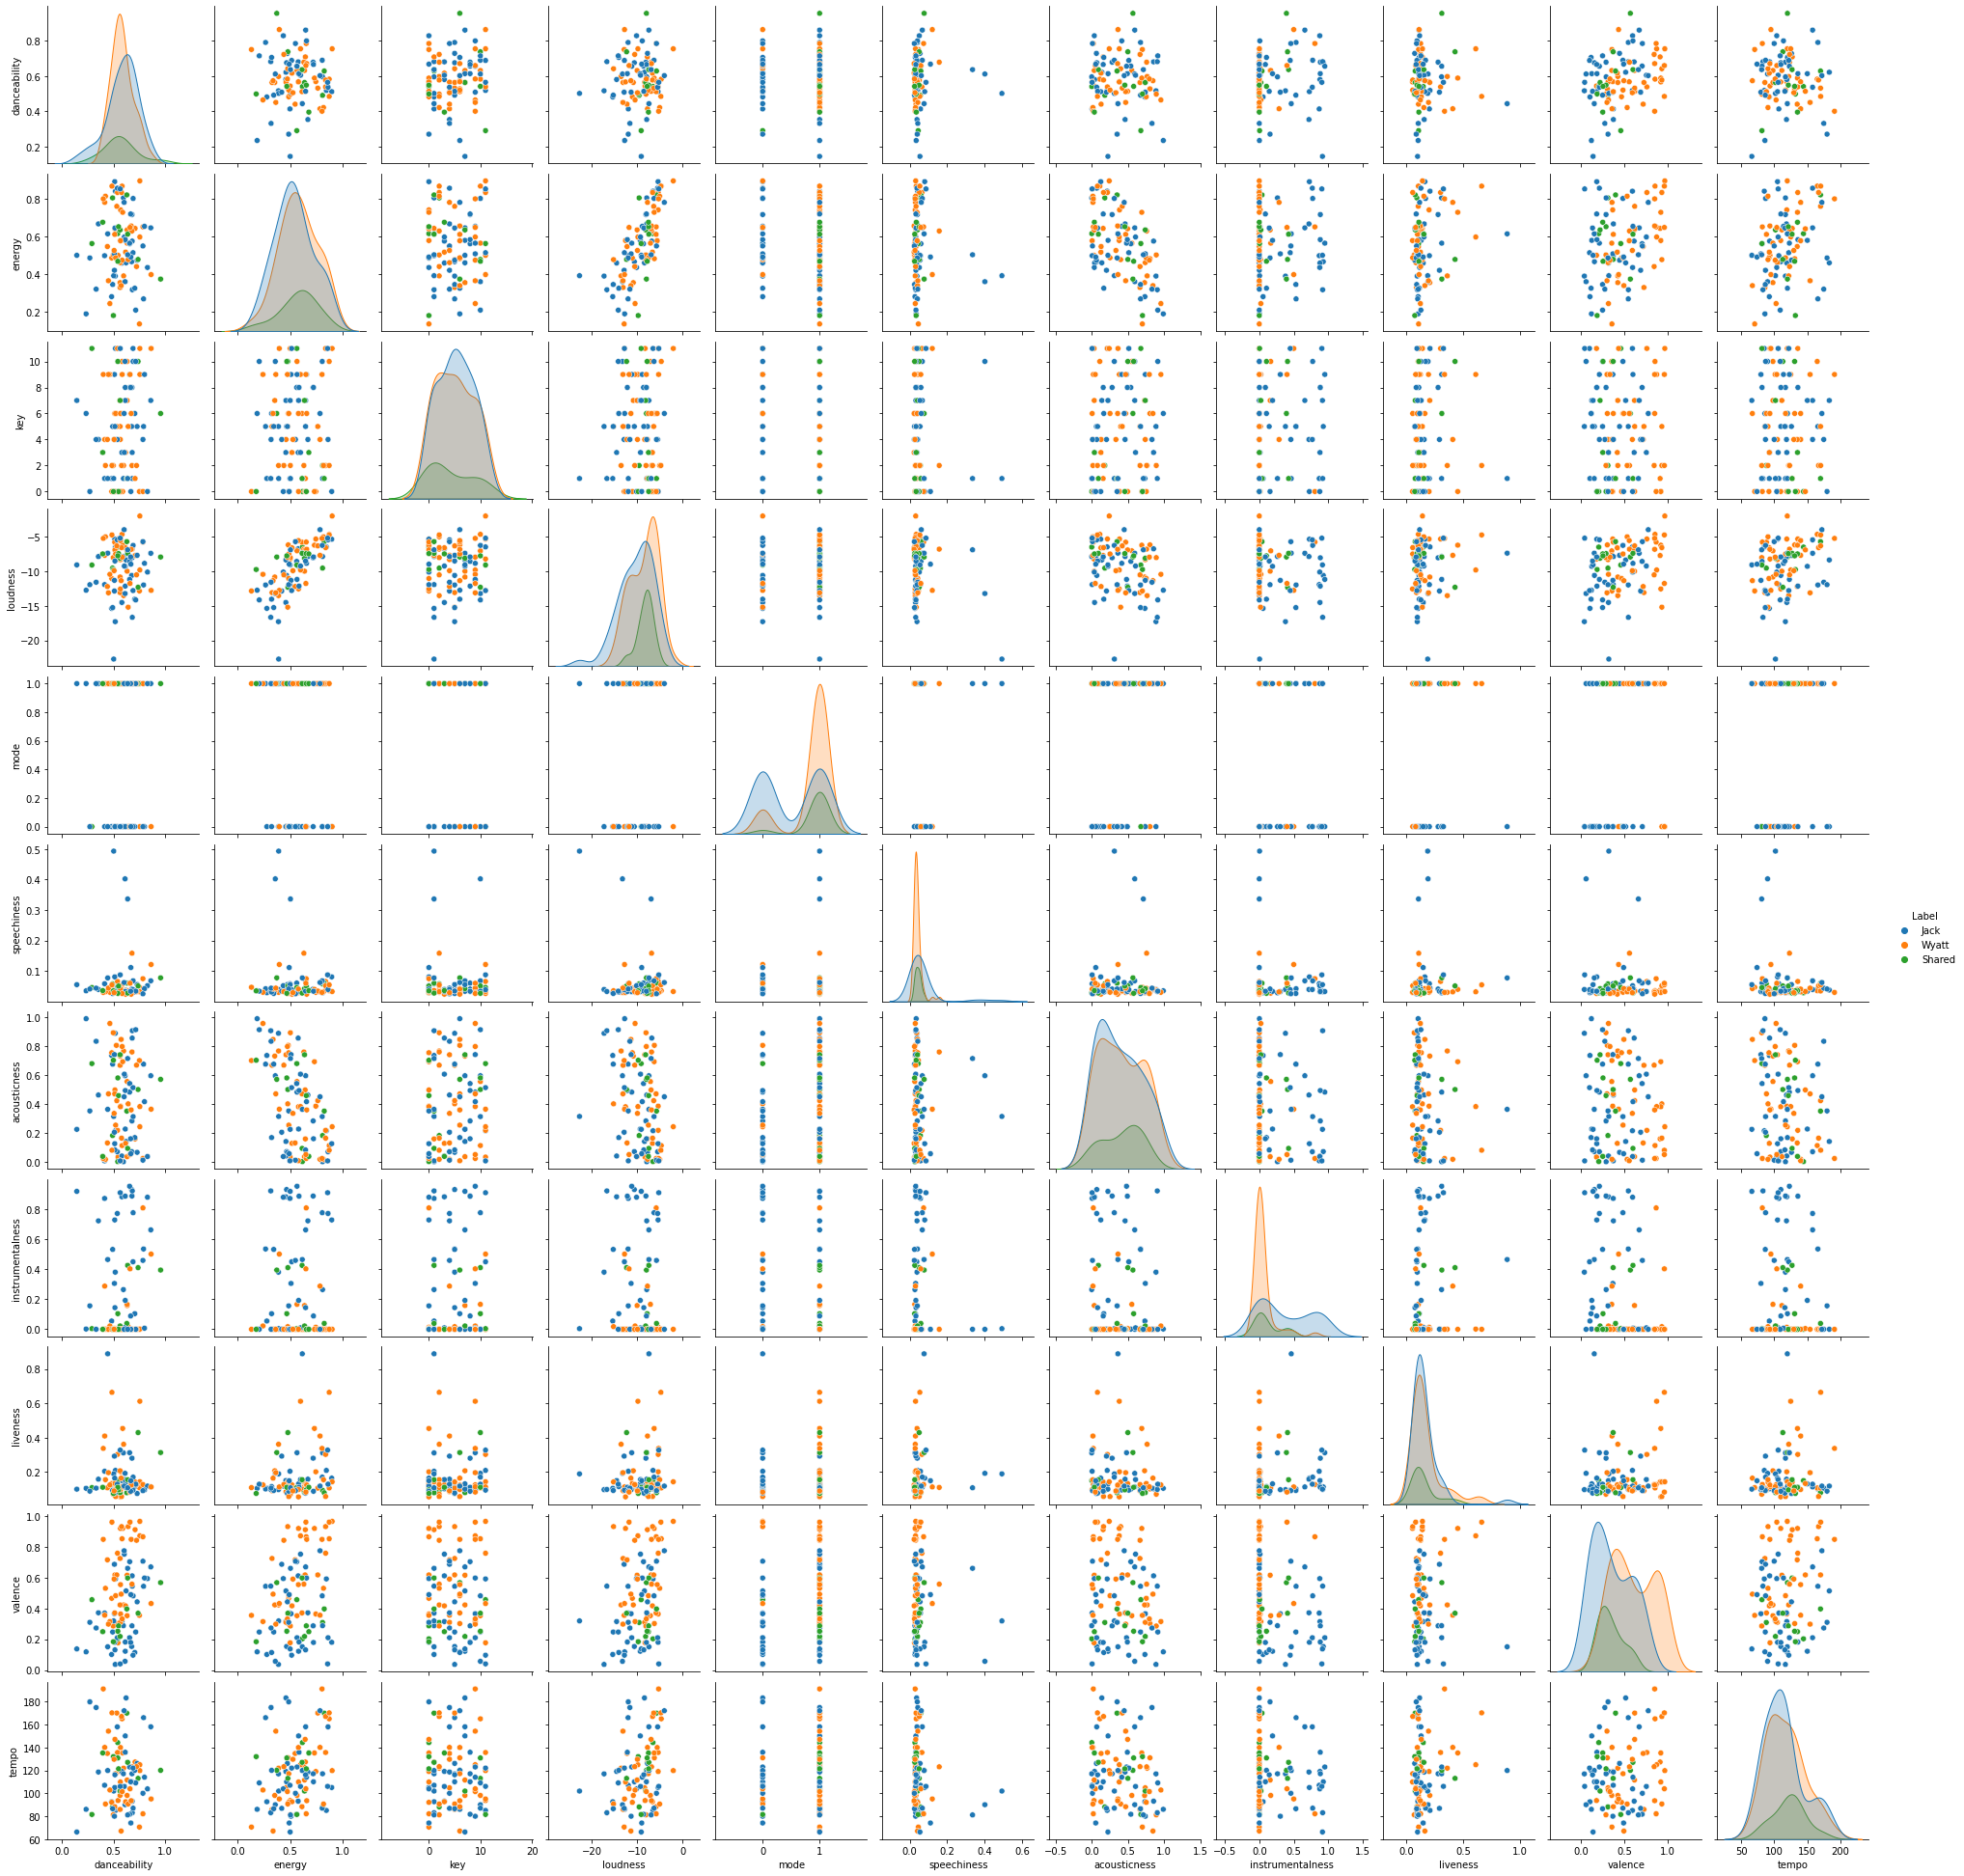

In [5]:
allsongfeaturesmod = dfall
allsongfeaturesmod.loc[sharedliked,'Label'] = 'Shared'

testfraction  = 100/len(allsongfeaturesmod)

X = allsongfeaturesmod
y = dfall['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testfraction, random_state=42)

forplotting = X_test[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence','tempo','Label']]
sns.pairplot(forplotting,hue = 'Label')

energy              0.563299
loudness            0.521697
acousticness        0.472967
valence             0.331242
liveness            0.189760
tempo               0.162809
speechiness         0.091622
danceability        0.071229
instrumentalness    0.024444
mode                0.016496
key                 0.015948
Name: 0, dtype: float64
instrumentalness    0.547233
mode                0.538649
valence             0.436188
danceability        0.258448
acousticness        0.213644
key                 0.186524
liveness            0.146128
tempo               0.138082
speechiness         0.120927
energy              0.112538
loudness            0.072071
Name: 1, dtype: float64


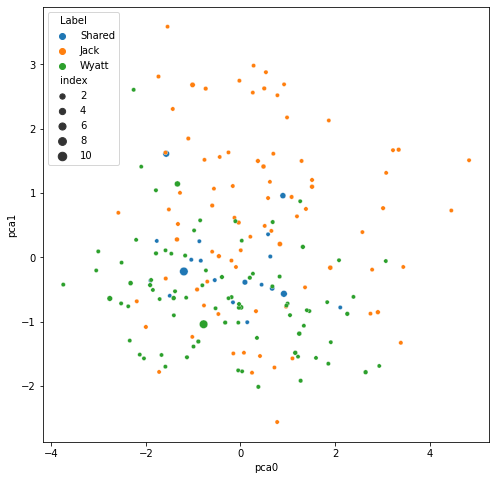

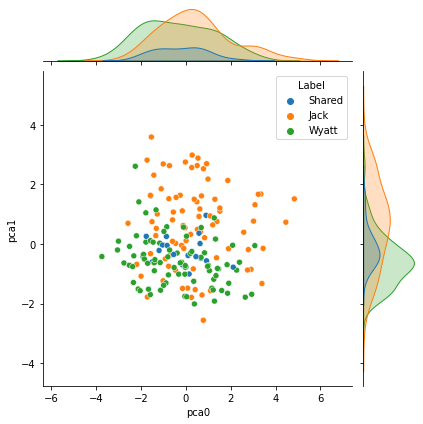

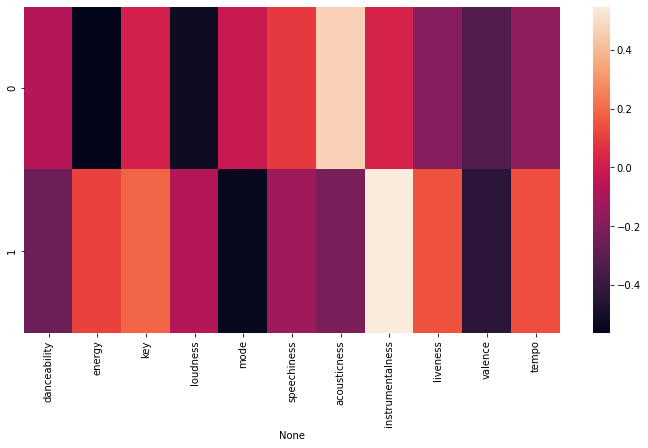

In [9]:
dfall.loc[sharedliked,'Label'] = 'Shared'
dfallfeatures = dfall[['danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo']]
# dfallfeatures = allsongfeaturesmod[['danceability', 'energy', 'key', 'loudness',
#        'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
#        'valence', 'tempo']]

scaler = StandardScaler()
scaler.fit(dfallfeatures)
dfscaled = scaler.transform(dfallfeatures)
dfscaled = pd.DataFrame(dfscaled,columns=dfallfeatures.columns)

pca = PCA(n_components=2)
pca.fit(dfscaled)
x_pca = pca.transform(dfscaled)
dfx_pca = pd.DataFrame(x_pca,columns=['pca0','pca1'])
dfx_pca['Label'] = dfall['Label']
dfx_pca['index'] = dfall['index']

# fig = plt.figure()
# plt.fig(figsize=(15,15))
# ax1 = fig.add_subplot(111)
plt.figure(figsize=(8, 8))
sns.scatterplot(data=dfx_pca, x='pca0', y="pca1",hue='Label',size="index")
sns.jointplot(data=dfx_pca, x='pca0', y="pca1",hue='Label')

pca.components_
df_comp = pd.DataFrame(pca.components_,columns=[dfscaled.columns])
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,)
print(df_comp.iloc[0].abs().sort_values(ascending=False))
print(df_comp.iloc[1].abs().sort_values(ascending=False))

In [ ]:
#add songs to playlist, won't overwrite just adds to end
#no option to create playlist without using browser/mobile platform
if token:
    sp = spotipy.Spotify(auth=token)
    sp.playlist_add_items('spotify:playlist:(plalist_id_here)', sharedlikedsongs['id'], position=None)

In [9]:
#Start of generating music classification and playlist from user saved data
#will need to recieve token using both peoples spotify login info

#get songs in multiples of 50
start = 0
df = get_songs(start)
for i in range(start+1,start+10):
    offset = i*50
    dfcurrent = get_songs(offset)
    print(offset)
    df = pd.concat([df,dfcurrent])
    i += 1
df = df.reset_index(drop=True)
df['Label'] = '0'
#dfpca = df[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
#        'acousticness', 'instrumentalness', 'liveness', 'valence','tempo','duration_ms','time_signature']]
#x_pca_all = library_pca(dfpca)

50
100
150
200
250
300
350
400
450


In [16]:
#create model for classifying songs for each user
#create list of songs which model has lowest confidence in classifying, represents the songs users tastes have in common

allsongfeatures = pd.concat([dfjack,dfamy])
numsongs = len(allsongfeatures)

allsongfeatures = allsongfeatures.reset_index(drop=True)

X = allsongfeatures[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence','tempo']]

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

from sklearn.model_selection import train_test_split

y = allsongfeatures['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#fit on everything
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X,y)

predictions = logmodel.predict(X)
predictionsproba = logmodel.predict_proba(X)
from sklearn.metrics import classification_report
print(classification_report(y,predictions))

# sharedliked = []
# for predict in enumerate(predictionsproba):
#     if .493 < predict[1][0] < .507:
#         sharedliked.append(predict[0])
# sharedliked
# sharedlikedsongs = allsongfeatures.iloc[sharedliked]

plusminus = 0
sharedliked = []
while len(sharedliked) < 19:  #number of songs in playlist to be made
    sharedliked = []
    plusminus += .001
    for predict in enumerate(predictionsproba):
        if .50-plusminus < predict[1][0] < .50+plusminus:
            sharedliked.append(predict[0])
print(len(sharedliked))
sharedliked
sharedlikedsongs = dfall.iloc[sharedliked]

from sklearn.utils import shuffle
sharedlikedsongsshuffled = shuffle(sharedlikedsongs).reset_index(drop=True)

len(sharedliked)

              precision    recall  f1-score   support

           0       0.65      0.63      0.64       500
           1       0.64      0.67      0.65       500

    accuracy                           0.65      1000
   macro avg       0.65      0.65      0.65      1000
weighted avg       0.65      0.65      0.65      1000



31

C:\Users\hogan\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


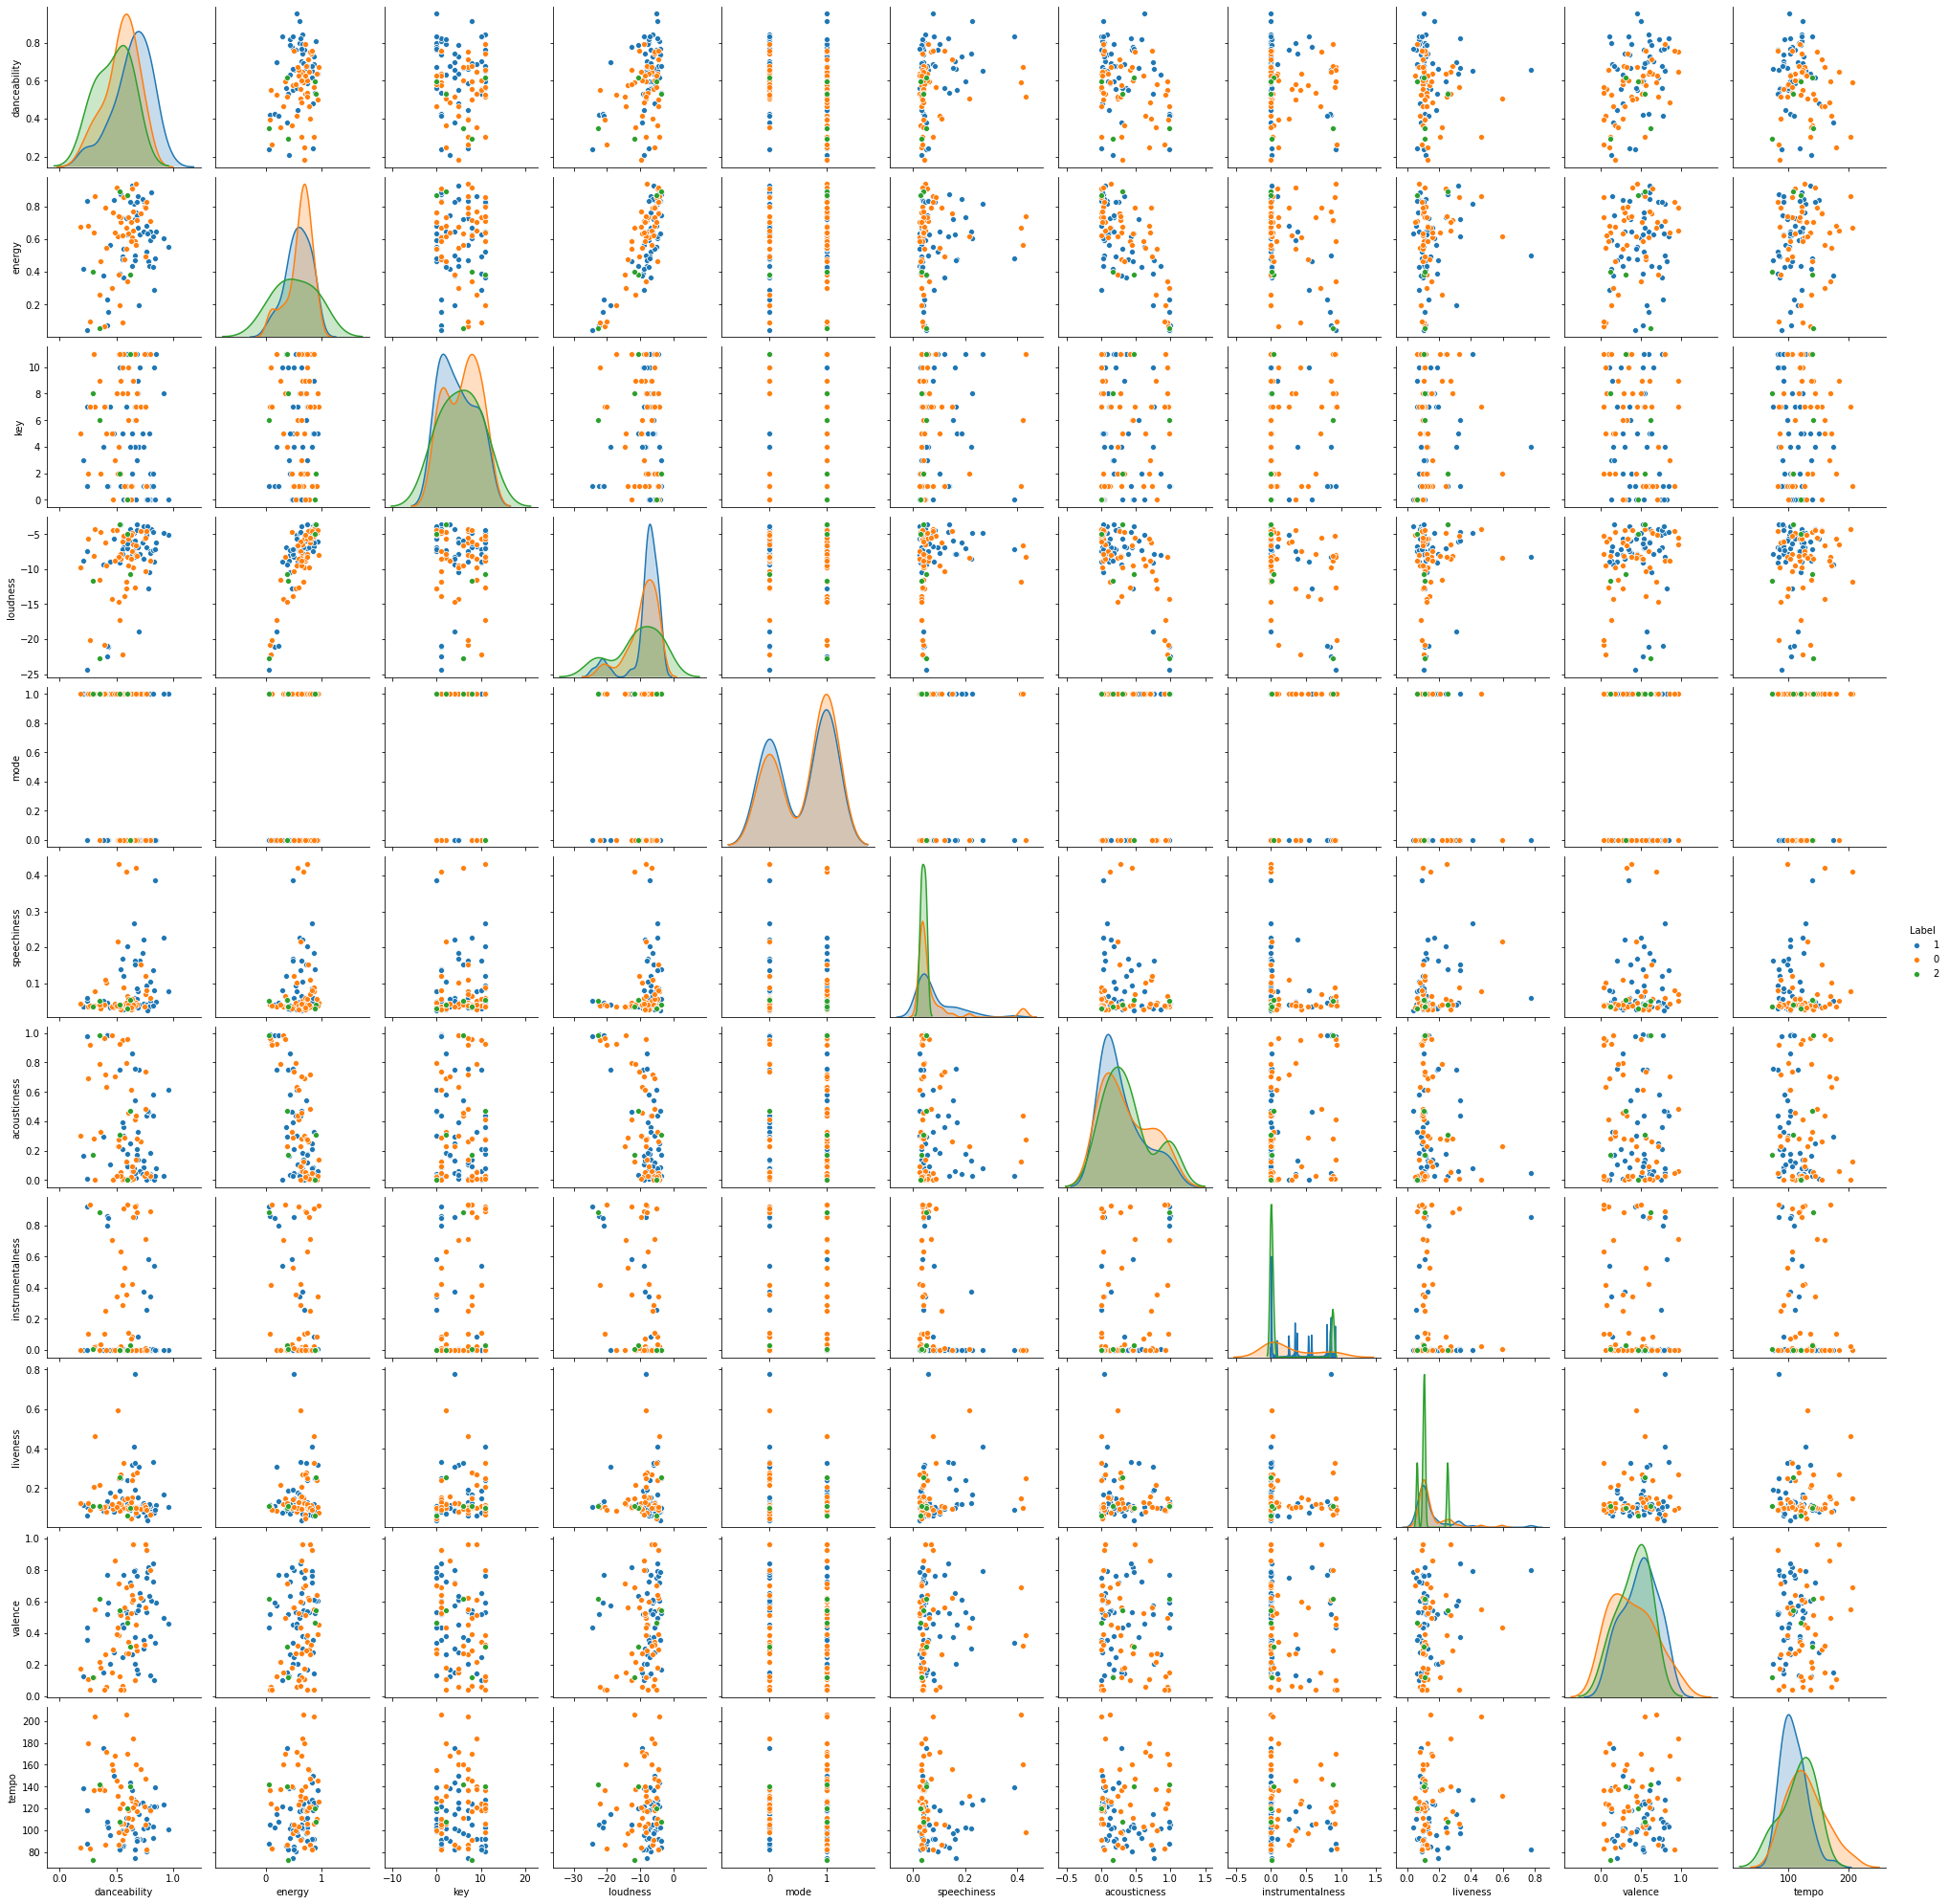

In [19]:
#pairplot of song features. 0 (blue) = first person, 1 (orange) = second person, 2 (green) = shared tastes, points fit had low confidence 
allsongfeaturesmod = allsongfeatures
allsongfeaturesmod.loc[sharedliked,'Label'] = 2

testfraction  = 100/len(allsongfeaturesmod)


X = allsongfeaturesmod
y = allsongfeatures['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testfraction, random_state=42)

forplotting = X_test[['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence','tempo','Label']]
sns.pairplot(forplotting,hue = 'Label')

jehogan1223


In [41]:
playlists

{'href': 'https://api.spotify.com/v1/users/jehogan1223/playlists?offset=0&limit=50',
 'items': [{'collaborative': False,
   'description': '',
   'external_urls': {'spotify': 'https://open.spotify.com/playlist/776hfdml3db3wa5mvNI80Z'},
   'href': 'https://api.spotify.com/v1/playlists/776hfdml3db3wa5mvNI80Z',
   'id': '776hfdml3db3wa5mvNI80Z',
   'images': [{'height': 640,
     'url': 'https://mosaic.scdn.co/640/ab67616d0000b27312720dbca7de20e4d48f7df6ab67616d0000b2735dcdfde4177b8d1173d56ff4ab67616d0000b273c8e9dc23f7f675dd7641b369ab67616d0000b273cdc2c370800cad705c9ed05d',
     'width': 640},
    {'height': 300,
     'url': 'https://mosaic.scdn.co/300/ab67616d0000b27312720dbca7de20e4d48f7df6ab67616d0000b2735dcdfde4177b8d1173d56ff4ab67616d0000b273c8e9dc23f7f675dd7641b369ab67616d0000b273cdc2c370800cad705c9ed05d',
     'width': 300},
    {'height': 60,
     'url': 'https://mosaic.scdn.co/60/ab67616d0000b27312720dbca7de20e4d48f7df6ab67616d0000b2735dcdfde4177b8d1173d56ff4ab67616d0000b273c8e9d